In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [7]:
data = pd.read_csv("input/data-attendance-1.txt")

## 問題設定

アルバイトが好きか（A)と学問への興味（Score）を入力に，出席率（Y)を予測したい．

In [8]:
data

,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230
5,0,133,0.350
6,0,111,0.330
7,1,147,0.194
8,0,146,0.413
9,0,145,0.360


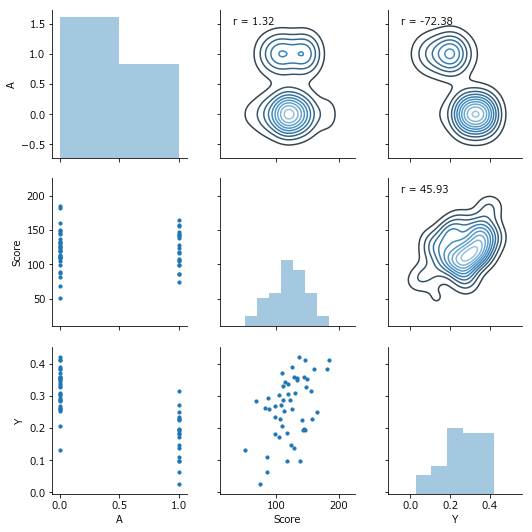

In [9]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r*100),
                xy=(.1, .9), xycoords=ax.transAxes)
g = sns.PairGrid(data, palette=["red"])
g.map_lower(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_upper(corrfunc)

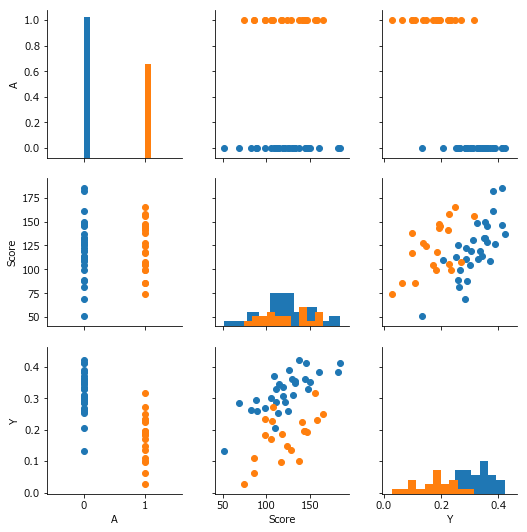

In [13]:
g = sns.PairGrid(data, hue="A")
g = g.map_upper(plt.scatter)
g = g.map_diag(plt.hist)
g = g.map_lower(plt.scatter)

$$\mu_i = b_1 + b_2 * A_i + b_3 * Score_i$$
$$Y_i \sim Normal(\mu_i, \sigma)$$

In [6]:
def model(a, score, y):
    b1 = pyro.sample("b1", dist.Normal(0, 100))
    b2 = pyro.sample("b2", dist.Normal(0, 100))
    b3 = pyro.sample("b3", dist.Normal(0, 100))
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 2.7))
    mu = b1 + b2 * a + b3 * score
    with pyro.plate("data", len(y)):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

In [7]:
a = torch.tensor(data.A).float()
score = torch.tensor(data.Score).float() / 200
y = torch.tensor(data.Y).float()

In [8]:
nuts_kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
mcmc_posterior = MCMC(nuts_kernel, num_chains=4, num_samples=1000, warmup_steps=1000).run(a, score, y)

In [9]:
sites = ["b1","b2","b3","sigma"]
d_mcmc = EmpiricalMarginal(mcmc_posterior, sites)._get_samples_and_weights()[0].detach().cpu().reshape(-1, len(sites)).numpy()

In [10]:
df_mcmc = pd.DataFrame(d_mcmc)
df_mcmc.columns = sites
df_mcmc_quantile = df_mcmc.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T
df_mcmc_quantile

,0.025,0.25,0.5,0.75,0.975
b1,0.058812,0.100538,0.123542,0.145377,0.185340
b2,-0.172165,-0.153195,-0.143780,-0.134262,-0.113339
b3,0.224250,0.289538,0.324971,0.359825,0.425455
sigma,0.042243,0.047678,0.051189,0.055307,0.063775


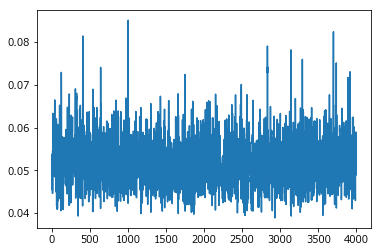

In [11]:
df_mcmc.sigma.plot()

In [12]:
df_mcmc.mean(axis=0) #EAP

b1       0.123009
b2      -0.143514
b3       0.325022
sigma    0.051722
dtype: float32

$$\mu_i = 0.124 - 0.144 * A_i + 0.324 * Score_i$$
$$Y_i \sim Normal(\mu_i, 0.052)$$

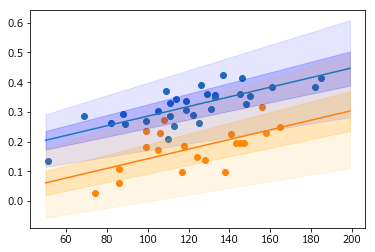

In [13]:
fig = plt.figure()
plt.scatter(data[data.A==0].Score, data[data.A==0].Y)
plt.scatter(data[data.A==1].Score, data[data.A==1].Y)
plt.plot(range(50, 200), df_mcmc.mean(axis=0).b1 + df_mcmc.mean(axis=0).b2 * 0 + df_mcmc.mean(axis=0).b3 * range(50, 200)/200)
plt.fill_between(range(50, 200),
                 df_mcmc_quantile[0.025].loc["b1"] + df_mcmc_quantile[0.025].loc["b2"] * 0 + df_mcmc_quantile[0.025].loc["b3"] * range(50, 200)/200,
                 df_mcmc_quantile[0.975].loc["b1"] + df_mcmc_quantile[0.975].loc["b2"] * 0 + df_mcmc_quantile[0.975].loc["b3"] * range(50, 200)/200, color='b', alpha=0.1)
plt.fill_between(range(50, 200),
                 df_mcmc_quantile[0.25].loc["b1"] + df_mcmc_quantile[0.25].loc["b2"] * 0 + df_mcmc_quantile[0.25].loc["b3"] * range(50, 200)/200,
                 df_mcmc_quantile[0.75].loc["b1"] + df_mcmc_quantile[0.75].loc["b2"] * 0 + df_mcmc_quantile[0.75].loc["b3"] * range(50, 200)/200, color='b', alpha=0.2)

plt.plot(range(50, 200), df_mcmc.mean(axis=0).b1 + df_mcmc.mean(axis=0).b2 * 1 + df_mcmc.mean(axis=0).b3 * range(50, 200)/200)
plt.fill_between(range(50, 200),
                 df_mcmc_quantile[0.025].loc["b1"] + df_mcmc_quantile[0.025].loc["b2"] * 1 + df_mcmc_quantile[0.025].loc["b3"] * range(50, 200)/200,
                 df_mcmc_quantile[0.975].loc["b1"] + df_mcmc_quantile[0.975].loc["b2"] * 1 + df_mcmc_quantile[0.975].loc["b3"] * range(50, 200)/200, color='orange', alpha=0.1)
plt.fill_between(range(50, 200),
                 df_mcmc_quantile[0.25].loc["b1"] + df_mcmc_quantile[0.25].loc["b2"] * 1 + df_mcmc_quantile[0.25].loc["b3"] * range(50, 200)/200,
                 df_mcmc_quantile[0.75].loc["b1"] + df_mcmc_quantile[0.75].loc["b2"] * 1 + df_mcmc_quantile[0.75].loc["b3"] * range(50, 200)/200, color='orange', alpha=0.2)

In [14]:
def predictive_model(a, score):
    b1 = pyro.sample("b1", dist.Normal(0, 100))
    b2 = pyro.sample("b2", dist.Normal(0, 100))
    b3 = pyro.sample("b3", dist.Normal(0, 100))
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 2.7))
    mu = b1 + b2 * a + b3 * score
    return pyro.sample("y", dist.Normal(mu, sigma))

In [15]:
predictive_distribution = TracePredictive(predictive_model, mcmc_posterior, num_samples=1000)

In [16]:
predict_result = EmpiricalMarginal(predictive_distribution.run(a, score), "y")._get_samples_and_weights()[0]

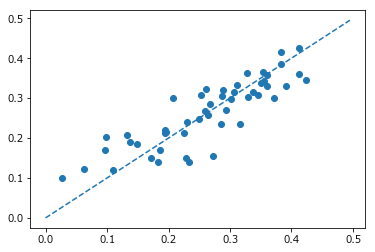

In [18]:
fig = plt.figure()
plt.plot(torch.arange(0, 100).numpy() / 200,torch.arange(0, 100).numpy() / 200, '--')
plt.scatter(data.Y, predict_result.mean(0).numpy())


In [19]:
kde = sm.nonparametric.KDEUnivariate(df_mcmc.sigma.values.astype("float64"))
kde.fit()
sigma_map = kde.support[np.argmax(kde.density)]

In [20]:
mus = (df_mcmc.b1.values.reshape(-1, 1) + np.dot(df_mcmc.b2.values.reshape(-1, 1), data.A.values.reshape(1, -1)) + np.dot(df_mcmc.b3.values.reshape(-1, 1), data.Score.values.reshape(1, -1)/200)).T

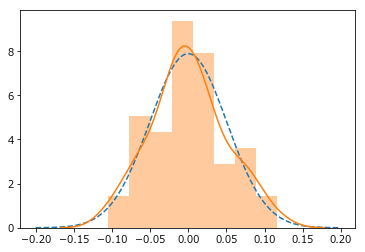

In [33]:
x = np.arange(-0.2, 0.2, 0.1/100)
y = stats.norm.pdf(x, loc=0, scale=sigma_map)
plt.plot(x, y, '--')
sns.distplot(data.Y.values - mus.mean(1))